Saving email_opened_table.csv to email_opened_table (1).csv
Saving email_table.csv to email_table (1).csv
Saving link_clicked_table.csv to link_clicked_table (1).csv
🔹 Open Rate: 10.35%
🔹 Click-Through Rate (CTR): 2.12%


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:54:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19547
           1       0.00      0.00      0.00       453

    accuracy                           0.98     20000
   macro avg       0.49      0.50      0.49     20000
weighted avg       0.96      0.98      0.97     20000

📈 AUC Score: 0.697585578247979
⭐ CTR for top 20% predicted users: 6.69%
⭐ Original CTR: 2.12%
📈 Estimated Improvement: 4.57%

📊 CTR by email_text:
email_text
short_email    2.387177
long_email     1.853767
Name: clicked, dtype: float64

📊 CTR by email_version:
email_version
personalized    2.729409
generic         1.513673
Name: clicked, dtype: float64

📊 CTR by hour:
hour
23    4.137931
24    2.898551
10    2.823961
11    2.712816
9     2.579435
12    2.566073
15    2.490696
16    2.319681
14    2.074236
13    1.988891
22    1.960784
3     1.952278
8     1.893308
17    1.848917
7     1.828376
1     1.812801
5     1.801252
6     1.714668
19

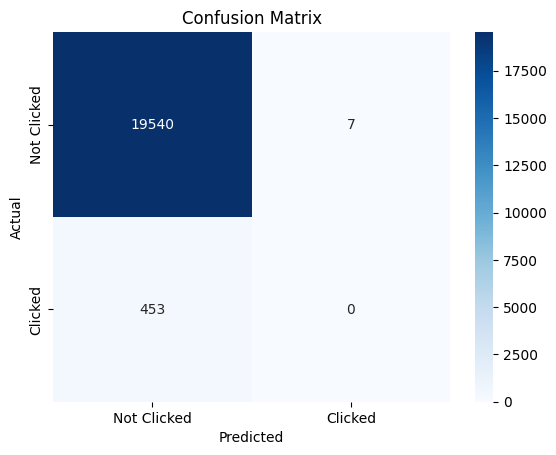

In [1]:
# 📌 Step 0: Install required libraries
!pip install pandas scikit-learn seaborn matplotlib xgboost --quiet

# 📌 Step 1: Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier

# 📌 Step 2: Load the data
from google.colab import files
uploaded = files.upload()

email_df = pd.read_csv('email_table.csv')
opened_df = pd.read_csv('email_opened_table.csv')
clicked_df = pd.read_csv('link_clicked_table.csv')

# 📌 Step 3: Basic metrics
total_sent = email_df.shape[0]
opened = email_df[email_df['email_id'].isin(opened_df['email_id'])].shape[0]
clicked = email_df[email_df['email_id'].isin(clicked_df['email_id'])].shape[0]

print(f"🔹 Open Rate: {opened / total_sent * 100:.2f}%")
print(f"🔹 Click-Through Rate (CTR): {clicked / total_sent * 100:.2f}%")

# 📌 Step 4: Label construction
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

# 📌 Step 5: Encode categorical features
features = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
X = email_df[features].copy()
y = email_df['clicked']

X['user_past_purchases'] = X['user_past_purchases'].fillna(0)

# Label Encoding for categorical columns
for col in ['email_text', 'email_version', 'weekday', 'user_country']:
    X[col] = LabelEncoder().fit_transform(X[col])

# 📌 Step 6: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 Step 7: Train the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 📌 Step 8: Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))
print("📈 AUC Score:", roc_auc_score(y_test, y_prob))

# 📌 Step 9: Estimate CTR gain
X['pred_prob'] = model.predict_proba(X)[:, 1]
top_20 = X.sort_values(by='pred_prob', ascending=False).head(int(0.2 * len(X)))
actual_ctr_top20 = email_df.loc[top_20.index, 'clicked'].mean()

print(f"⭐ CTR for top 20% predicted users: {actual_ctr_top20 * 100:.2f}%")
print(f"⭐ Original CTR: {clicked / total_sent * 100:.2f}%")
print(f"📈 Estimated Improvement: {(actual_ctr_top20 - clicked / total_sent) * 100:.2f}%")

# 📌 Step 10: Segment Analysis
segment_cols = ['email_text', 'email_version', 'hour', 'weekday', 'user_country']
for col in segment_cols:
    print(f"\n📊 CTR by {col}:")
    print(email_df.groupby(col)['clicked'].mean().sort_values(ascending=False) * 100)

# 📌 Optional: Heatmap of confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Clicked", "Clicked"], yticklabels=["Not Clicked", "Clicked"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
